In [55]:
import os
import ast
import random
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.losses import MeanAbsoluteError as MeanAbsoluteErrorLoss
from tensorflow.keras.layers import LSTM, Dense, Input, Bidirectional, BatchNormalization, Dropout
from tensorflow.keras.metrics import MeanAbsoluteError as MeanAbsoluteErrorMetric, RootMeanSquaredError

In [24]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [25]:
EXPECTED_FRAMES = 10
EXPECTED_FEATURES = 6

In [ ]:
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)
os.makedirs(records_dir, exist_ok=True)

In [27]:
def score_to_label(score):
    if score < 0.5:
        return 0
    elif score < 0.8:
        return 1
    else:
        return 2
    
def label_to_score(label):
    if label == 0:
        return 0.0
    elif label == 1:
        return 0.5
    else:
        return 1.0

In [28]:
def plot_training_history(history, y_true=None, y_pred=None):
    plt.figure(figsize=(18, 5))

    # --- Subplot 1: Loss ---
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # --- Subplot 2: Metrics ---
    plt.subplot(1, 3, 2)
    if 'mean_absolute_error' in history.history:
        plt.plot(history.history['mean_absolute_error'], label='Training MAE')
    if 'root_mean_squared_error' in history.history:
        plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
    if 'val_mean_absolute_error' in history.history:
        plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
    if 'val_root_mean_squared_error' in history.history:
        plt.plot(history.history['val_root_mean_squared_error'], label='Val RMSE')
    plt.title('Metrics over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()

    # --- Subplot 3: Predicted vs True ---
    if y_true is not None and y_pred is not None:
        plt.subplot(1, 3, 3)
        plt.scatter(y_true, y_pred, alpha=0.4)
        plt.plot([0, 1], [0, 1], 'r--')  # identity line
        plt.xlabel("True Engagement Score")
        plt.ylabel("Predicted Engagement Score")
        plt.title("True vs Predicted Engagement")
        plt.grid(True)

    plt.tight_layout()
    plt.show()


In [29]:
df = pd.read_csv("oversampled_data.csv")

In [30]:
df['features'] = df['features'].apply(ast.literal_eval)
df['engagement_score'] = df['engagement_class'].apply(label_to_score)

train_df = df[df['split'] == "Train"].reset_index(drop=True)
val_df = df[df['split'] == "Validation"].reset_index(drop=True)
test_df = df[df['split'] == "Test"].reset_index(drop=True)

X_train = np.array(train_df['features'].tolist(), dtype=np.float32)
y_train = train_df['engagement_score'].values

X_val = np.array(val_df['features'].tolist(), dtype=np.float32)
y_val = val_df['engagement_score'].values

X_test = np.array(test_df['features'].tolist(), dtype=np.float32)
y_test = test_df['engagement_score'].values

In [31]:
X_train_2d = X_train.reshape(-1, X_train.shape[2])
X_val_2d = X_val.reshape(-1, X_val.shape[2])
X_test_2d = X_test.reshape(-1, X_test.shape[2])

scaler = StandardScaler()
X_train_scaled_2d = scaler.fit_transform(X_train_2d)
X_val_scaled_2d = scaler.transform(X_val_2d)
X_test_scaled_2d = scaler.transform(X_test_2d)

X_train_normalized = X_train_scaled_2d.reshape(X_train.shape)
X_val_normalized = X_val_scaled_2d.reshape(X_val.shape)
X_test_normalized = X_test_scaled_2d.reshape(X_test.shape)

means = scaler.mean_
stds = np.sqrt(scaler.var_)

train_labels = train_df['engagement_class'].values
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

sample_weights = np.array([class_weights[label] for label in train_labels])

print("Training Feature Means:", means)
print("Training Feature STDs:", stds)

Training Feature Means: [ 2.63725628  0.24754904 20.03774123 11.40487964  7.34959163 80.09556415]
Training Feature STDs: [1.88024464e-01 5.81533575e-02 5.77037380e+00 8.39637132e+01
 4.89170912e+01 1.13629599e+01]


In [ ]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"lstm_sigmoid_model_{timestamp}.h5"
model_filepath = os.path.join(model_dir, model_filename)
log_filepath = 'training_history.csv'

In [78]:
OPTIMIZER = Adam(learning_rate=1e-3)
LOSS = MeanAbsoluteErrorLoss()
METRICS = [
    MeanAbsoluteErrorMetric(),
    RootMeanSquaredError(),
]
BATCH_SIZE = 16
EPOCHS = 100
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_mean_absolute_error",
        factor=0.5,
        patience=8,
        min_lr=1e-6,
        verbose=1
    )
]

model = Sequential(
    [
        Input(shape=(EXPECTED_FRAMES, EXPECTED_FEATURES)),
        Bidirectional(LSTM(64, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.4),
        LSTM(32,return_sequences=False),
        BatchNormalization(),
        Dropout(0.4),
        Dense(16, activation="relu"),
        Dropout(0.4),
        Dense(1, activation="sigmoid"),
    ]
)

model.compile(
    optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS
)

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirecti  (None, 10, 128)           36352     
 onal)                                                           
                                                                 
 batch_normalization_16 (Ba  (None, 10, 128)           512       
 tchNormalization)                                               
                                                                 
 dropout_24 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_17 (LSTM)              (None, 32)                20608     
                                                                 
 batch_normalization_17 (Ba  (None, 32)                128       
 tchNormalization)                                               
                                                      

In [79]:
history = model.fit(
    X_train_normalized,
    y_train,
    sample_weight=sample_weights,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_normalized, y_val),
    verbose=1,
    callbacks=callbacks
)

Epoch 1/100
417/417 [==============================] - 17s 28ms/step - loss: 0.3757 - mean_absolute_error: 0.3681 - root_mean_squared_error: 0.4541 - val_loss: 0.4019 - val_mean_absolute_error: 0.4019 - val_root_mean_squared_error: 0.4952 - lr: 0.0010
Epoch 2/100
417/417 [==============================] - 10s 25ms/step - loss: 0.3429 - mean_absolute_error: 0.3321 - root_mean_squared_error: 0.4200 - val_loss: 0.3763 - val_mean_absolute_error: 0.3763 - val_root_mean_squared_error: 0.4825 - lr: 0.0010
Epoch 3/100
417/417 [==============================] - 10s 24ms/step - loss: 0.3284 - mean_absolute_error: 0.3144 - root_mean_squared_error: 0.4040 - val_loss: 0.3663 - val_mean_absolute_error: 0.3663 - val_root_mean_squared_error: 0.4745 - lr: 0.0010
Epoch 4/100
417/417 [==============================] - 10s 25ms/step - loss: 0.3178 - mean_absolute_error: 0.3050 - root_mean_squared_error: 0.4004 - val_loss: 0.3640 - val_mean_absolute_error: 0.3640 - val_root_mean_squared_error: 0.4657 - lr:

In [80]:
y_pred = model.predict(X_test_normalized).flatten()
y_true = y_test
y_pred_labels = np.array([score_to_label(s) for s in y_pred])
y_true_labels = np.array([score_to_label(s) for s in y_true])

mae = np.mean(np.abs(y_true-y_pred))
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

classification_rep = classification_report(y_true_labels,y_pred_labels)
confusion_mat = confusion_matrix(y_true_labels,y_pred_labels)

per_class_metrics = {}

for cls in [0, 1, 2]:
    cls_indices = y_true_labels == cls
    cls_y_true = y_true[cls_indices]
    cls_y_pred = y_pred[cls_indices]

    if len(cls_y_true) == 0:
        print(f"Class {cls} — No samples found in test set, skipping metrics.")
        continue

    cls_mae = mean_absolute_error(cls_y_true, cls_y_pred)
    cls_rmse = np.sqrt(mean_squared_error(cls_y_true, cls_y_pred))
    per_class_metrics[f'class_{cls}_mae'] = cls_mae
    per_class_metrics[f'class_{cls}_rmse'] = cls_rmse
    print(f"Class {cls} — MAE: {cls_mae:.4f}, RMSE: {cls_rmse:.4f}")

    
print("classification report:")
print(classification_rep)
print("confusion matrix:")
print(confusion_mat)

66/66 [==============================] - 2s 10ms/step
Class 0 — MAE: 0.4684, RMSE: 0.5277
Class 1 — MAE: 0.0582, RMSE: 0.1555
Class 2 — MAE: 0.4984, RMSE: 0.5373
classification report:
              precision    recall  f1-score   support

           0       0.20      0.76      0.32       468
           1       0.28      0.06      0.10       857
           2       0.42      0.09      0.15       772

    accuracy                           0.23      2097
   macro avg       0.30      0.30      0.19      2097
weighted avg       0.31      0.23      0.17      2097

confusion matrix:
[[354  70  44]
 [753  53  51]
 [637  67  68]]


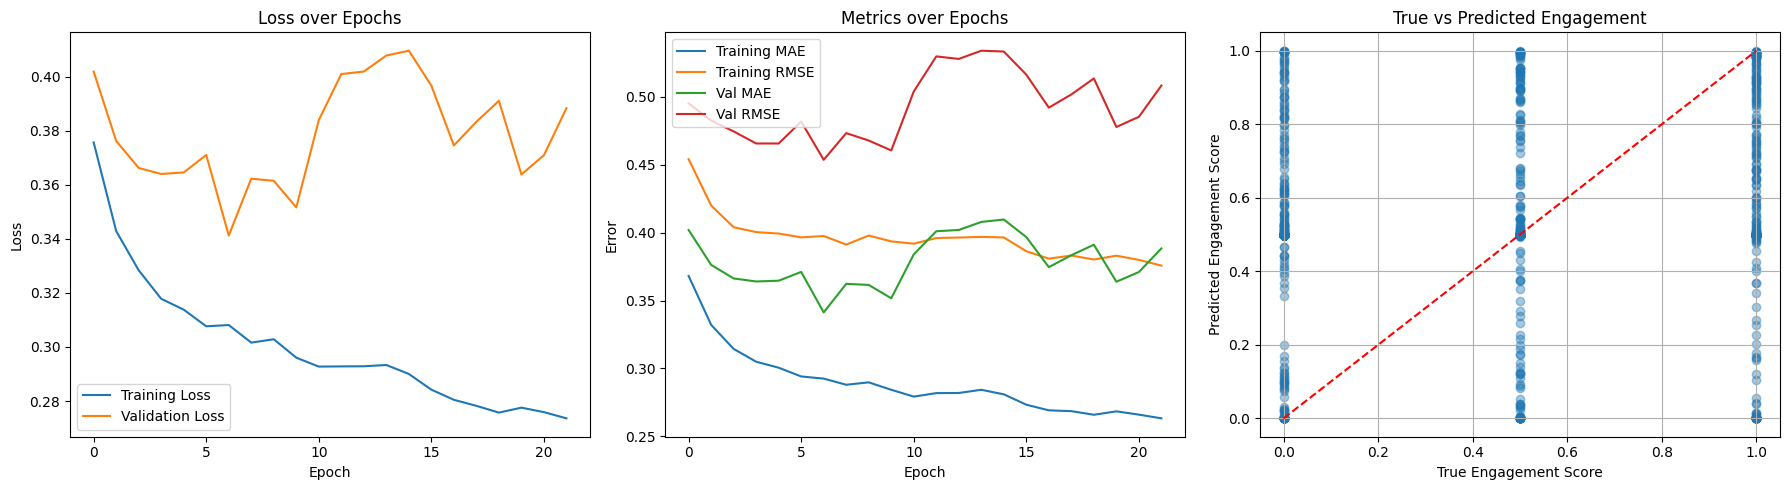

In [81]:
plot_training_history(history,y_true,y_pred)

In [82]:
model.save(model_filepath)

f:\dev\projects\GEDs\engagement_detetcion\.venv_38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [83]:
write_header = not os.path.exists(log_filepath)

log_data = {
    'timestamp': [timestamp],
    'model_file': [model_filepath],
    'epochs': [EPOCHS],
    'batch_size': [BATCH_SIZE],
    'optimizer': [OPTIMIZER],
    'loss_function': [LOSS],
    'model_layers': [
        " > ".join([layer.__class__.__name__ for layer in model.layers])
    ],
    'train_loss': [history.history['loss'][-1]],
    'val_loss': [history.history['val_loss'][-1]],
    'rmse': [rmse]
}

log_data.update({k: [v] for k, v in per_class_metrics.items()})

df_log = pd.DataFrame(log_data)

df_log.to_csv(log_filepath, mode='a', header=write_header, index=False)